# PyThia

PyThia performs video prediction for simple physical systems:
given initial video frames, what will a future video frame look like?

## Technical preliminaries

We install the `pythia` package and import it.
We also import other libraries, or tools from other libraries, which will be of use.

In [1]:
pip install git+https://github.com/aremondtiedrez/pythia.git

  Cloning https://github.com/aremondtiedrez/pythia.git to /tmp/pip-req-build-x44k9t8u
  Running command git clone --filter=blob:none --quiet https://github.com/aremondtiedrez/pythia.git /tmp/pip-req-build-x44k9t8u
  Resolved https://github.com/aremondtiedrez/pythia.git to commit 321c5c3d9422abb0a3c9563336babbed6f4ec060
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pythia: filename=pythia-0.1.0-py3-none-any.whl size=106591 sha256=47888274340ae9dc804b62d6d02d81a3c44109898f621bf02a6b3275a09cc760
  Stored in directory: /tmp/pip-ephem-wheel-cache-yxqz0o8k/wheels/73/60/af/5a848e3ca8f5fdcf403911aacc928f3a3fb8578d5add2726bf
Successfully built pythia


In [2]:
import numpy as np

import pythia

## IN PROGRESS

In [3]:
snapshot_timesteps, positions, velocities, images = pythia.demo.load_demo_data()

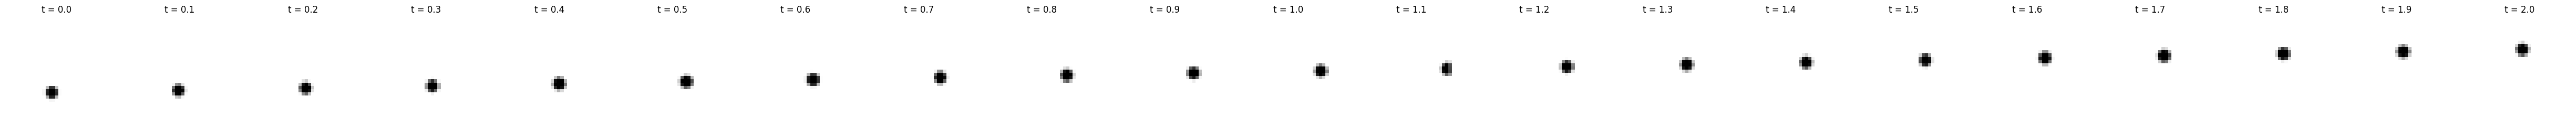

Initial velocity:        [120.4347485   69.04166973]
Position at t = 0.0: [113.09679932  46.09058718]
Position at t = 0.1: [125.14027417  52.99475415]
Position at t = 0.2: [137.18374902  59.89892112]
Position at t = 0.3: [149.34765862  66.87212976]
Position at t = 0.4: [161.27069872  73.70725507]
Position at t = 0.5: [173.31417357  80.61142204]
Position at t = 0.6: [185.47808317  87.58463068]
Position at t = 0.7: [197.40112327  94.41975598]
Position at t = 0.8: [209.44459812 101.32392296]
Position at t = 0.9: [221.48807297 108.22808993]
Position at t = 1.0: [233.53154782 115.1322569 ]
Position at t = 1.1: [245.57502267 122.03642388]
Position at t = 1.2: [234.37459106 129.00963252]
Position at t = 1.3: [222.45155096 135.84475782]
Position at t = 1.4: [210.40807611 142.74892479]
Position at t = 1.5: [198.36460126 149.65309177]
Position at t = 1.6: [186.32112641 156.55725874]
Position at t = 1.7: [174.15721681 163.53046738]
Position at t = 1.8: [162.23417671 170.36559268]
Position at t = 

In [4]:
pythia.visualization.inspect(snapshot_timesteps, positions[0], velocities[0], images[0])